In [865]:
import numpy as np
import pandas as pd
from datetime import datetime

import plotly.graph_objects as go
from ta.trend import MACD

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


from matplotlib import pyplot as plt

pd.get_option("display.max_columns")

20

In [866]:
def load_configs(config: str = "btc"):
    is_time_aggregate = False
    if config == "btc":
        filename = "test.csv"
        trades_per_candle = 1000
        do_aggregate = False
        df = pd.read_csv(filename, header=None, names=["Open", "High", "Low", "Close", "Volume", "Timestamp", "SelltoBuy"])
    elif config == "etc":        
        filename = "test_ethusd.csv"
        trades_per_candle = 1000
        do_aggregate = True
        df = pd.read_csv(filename, header=None, names=["Open", "High", "Low", "Close", "Volume", "Timestamp", "SelltoBuy"])
    else:
        filename = "test_ethusdt_time_series.csv"
        trades_per_candle = 1000
        do_aggregate = False
        df = pd.read_csv(filename, header=None, names=["Open", "High", "Low", "Close", "Volume", "Timestamp", "SelltoBuy", "Trades"])
        is_time_aggregate = True
    threshold = 0.15
    return filename, trades_per_candle, do_aggregate, threshold, df, is_time_aggregate

filename, trades_per_candle, do_aggregate, threshold, df, is_time_aggregate = load_configs("else")

In [867]:
df["Timestamp"] = df["Timestamp"].apply(lambda row: pd.to_datetime(row,unit='ms'))

def draw(df):
    fig = go.Figure(data=[go.Candlestick(x=df['Timestamp'],
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()
draw(df)

In [868]:
df.head(50)

,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,Trades
0,2900.48,2903.03,2899.28,2902.23,5.644723e+05,2021-09-28 10:30:34.524,140,361
1,2902.08,2902.23,2894.81,2896.95,8.312620e+05,2021-09-28 10:31:34.911,250,431
2,2896.99,2902.34,2896.99,2901.09,5.649050e+05,2021-09-28 10:32:35.495,162,284
3,2901.34,2904.62,2900.80,2904.62,3.378702e+05,2021-09-28 10:33:35.565,99,251
4,2904.63,2906.77,2903.32,2905.66,8.657689e+05,2021-09-28 10:34:35.747,230,469
5,2905.66,2905.66,2898.45,2901.02,2.868255e+05,2021-09-28 10:35:36.178,168,277
6,2901.01,2905.01,2900.00,2904.94,3.505611e+05,2021-09-28 10:36:36.953,136,267
7,2904.94,2906.06,2902.22,2903.05,3.088425e+05,2021-09-28 10:37:36.960,155,276
8,2903.14,2903.14,2898.29,2899.71,9.597596e+05,2021-09-28 10:38:38.481,211,487
9,2899.60,2899.92,2893.44,2897.53,1.067996e+06,2021-09-28 10:39:38.776,340,610


In [869]:
def aggregate(each: int = 10):
    new_df = pd.DataFrame()
    new_df["Open"] = df["Open"].groupby(df.index // each).first()
    new_df["High"] = df["High"].groupby(df.index // each).max()
    new_df["Low"] = df["Low"].groupby(df.index // each).min()
    new_df["Close"] = df["Close"].groupby(df.index // each).last()
    new_df["Volume"] = df["Volume"].groupby(df.index // each).sum()
    new_df["Timestamp"] = df["Timestamp"].groupby(df.index // each).min()
    new_df["SelltoBuy"] = df["SelltoBuy"].groupby(df.index // each).sum()
    return new_df

if do_aggregate:
    new_df = aggregate()

In [870]:
if do_aggregate:
    df = new_df
    draw(df)

In [871]:
df.tail(50)

,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,Trades
296,2865.42,2869.18,2864.05,2867.60,2.897462e+06,2021-09-28 15:34:38.063,673,1174
297,2867.74,2868.87,2863.12,2865.22,7.700279e+05,2021-09-28 15:35:38.076,379,669
298,2865.41,2869.78,2865.22,2866.59,1.105007e+06,2021-09-28 15:36:38.438,417,702
299,2866.65,2866.65,2861.86,2864.68,1.250163e+06,2021-09-28 15:37:38.585,449,681
300,2864.69,2865.23,2862.15,2864.87,1.299380e+06,2021-09-28 15:38:38.883,435,619
301,2864.87,2869.19,2864.67,2868.32,1.115527e+06,2021-09-28 15:39:39.758,241,551
302,2868.31,2868.31,2863.67,2866.21,7.980359e+05,2021-09-28 15:40:39.975,388,646
303,2865.69,2866.29,2861.00,2865.10,7.053535e+05,2021-09-28 15:41:40.126,349,565
304,2864.97,2865.43,2861.35,2862.31,4.709413e+05,2021-09-28 15:42:41.189,300,487
305,2862.32,2862.32,2856.00,2858.08,1.082497e+06,2021-09-28 15:43:41.414,551,833


In [872]:
# df.to_csv('ethbtc.csv', index=False)

In [873]:
def create_signal(signal_col_name:str = "simple_signal", buy_side_col:str = "pct_change", sell_side_col:str = "pct_change"):
    conditions = [(df[buy_side_col] > threshold), (df[sell_side_col] < -threshold)]
    choices = [1, -1]
    df[signal_col_name] = np.select(conditions, choices, default=0)


def signal_analytics(signal_col_name: str = "simple_signal"):
    signals_total = df[signal_col_name][df[signal_col_name] != 0].count()
    df_len = len(df)
    print(f"Buy signals total: {df[signal_col_name][df[signal_col_name] > 0].sum()}")
    print(f"Sell signals total: {abs(df[signal_col_name][df[signal_col_name] < 0].sum())}")
    print(f"Signals total: {signals_total}")
    print(f"Candles observed: {df_len}")
    print(f"Signal to candle ratio: {round(signals_total/df_len, 4)*100}%")


In [874]:
df['pct_change'] = df["Close"].pct_change() * 100

create_signal()
signal_analytics()
df.tail(50)

Buy signals total: 34
Sell signals total: 37
Signals total: 71
Candles observed: 346
Signal to candle ratio: 20.52%


,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,Trades,pct_change,simple_signal
296,2865.42,2869.18,2864.05,2867.60,2.897462e+06,2021-09-28 15:34:38.063,673,1174,0.087257,0
297,2867.74,2868.87,2863.12,2865.22,7.700279e+05,2021-09-28 15:35:38.076,379,669,-0.082996,0
298,2865.41,2869.78,2865.22,2866.59,1.105007e+06,2021-09-28 15:36:38.438,417,702,0.047815,0
299,2866.65,2866.65,2861.86,2864.68,1.250163e+06,2021-09-28 15:37:38.585,449,681,-0.066630,0
300,2864.69,2865.23,2862.15,2864.87,1.299380e+06,2021-09-28 15:38:38.883,435,619,0.006633,0
301,2864.87,2869.19,2864.67,2868.32,1.115527e+06,2021-09-28 15:39:39.758,241,551,0.120424,0
302,2868.31,2868.31,2863.67,2866.21,7.980359e+05,2021-09-28 15:40:39.975,388,646,-0.073562,0
303,2865.69,2866.29,2861.00,2865.10,7.053535e+05,2021-09-28 15:41:40.126,349,565,-0.038727,0
304,2864.97,2865.43,2861.35,2862.31,4.709413e+05,2021-09-28 15:42:41.189,300,487,-0.097379,0
305,2862.32,2862.32,2856.00,2858.08,1.082497e+06,2021-09-28 15:43:41.414,551,833,-0.147783,0


In [875]:
df['open_high_pct_change'] = (df['High'] - df['Open']) / df['Open'] * 100
df['open_low_pct_change'] = (df["Low"] - df["Open"]) / df["Open"] * 100

signal_take_profit = "signal_take_profit"

create_signal(signal_take_profit, "open_high_pct_change", "open_low_pct_change")
signal_analytics(signal_col_name = signal_take_profit)

df.tail(50)

Buy signals total: 88
Sell signals total: 82
Signals total: 170
Candles observed: 346
Signal to candle ratio: 49.13%


,Open,High,Low,Close,Volume,Timestamp,SelltoBuy,Trades,pct_change,simple_signal,open_high_pct_change,open_low_pct_change,signal_take_profit
296,2865.42,2869.18,2864.05,2867.60,2.897462e+06,2021-09-28 15:34:38.063,673,1174,0.087257,0,0.131220,-0.047811,0
297,2867.74,2868.87,2863.12,2865.22,7.700279e+05,2021-09-28 15:35:38.076,379,669,-0.082996,0,0.039404,-0.161102,-1
298,2865.41,2869.78,2865.22,2866.59,1.105007e+06,2021-09-28 15:36:38.438,417,702,0.047815,0,0.152509,-0.006631,1
299,2866.65,2866.65,2861.86,2864.68,1.250163e+06,2021-09-28 15:37:38.585,449,681,-0.066630,0,0.000000,-0.167094,-1
300,2864.69,2865.23,2862.15,2864.87,1.299380e+06,2021-09-28 15:38:38.883,435,619,0.006633,0,0.018850,-0.088666,0
301,2864.87,2869.19,2864.67,2868.32,1.115527e+06,2021-09-28 15:39:39.758,241,551,0.120424,0,0.150792,-0.006981,1
302,2868.31,2868.31,2863.67,2866.21,7.980359e+05,2021-09-28 15:40:39.975,388,646,-0.073562,0,0.000000,-0.161768,-1
303,2865.69,2866.29,2861.00,2865.10,7.053535e+05,2021-09-28 15:41:40.126,349,565,-0.038727,0,0.020937,-0.163660,-1
304,2864.97,2865.43,2861.35,2862.31,4.709413e+05,2021-09-28 15:42:41.189,300,487,-0.097379,0,0.016056,-0.126354,0
305,2862.32,2862.32,2856.00,2858.08,1.082497e+06,2021-09-28 15:43:41.414,551,833,-0.147783,0,0.000000,-0.220800,-1


In [876]:
df["sell_to_buy_ratio"] = (df["SelltoBuy"] / trades_per_candle) if not is_time_aggregate else df["SelltoBuy"] / df["Trades"] 
df = df.drop(columns=["SelltoBuy"])

In [877]:
# df["secs_between_candles"] = df["Timestamp"] - df["Timestamp"].shift(1)
# df["secs_between_candles"] = df['secs_between_candles'].dt.total_seconds()
df = df.drop(columns=["Timestamp"])

In [878]:
df["ss_next"] = df["simple_signal"].shift(-1)
df["stp_next"] = df["signal_take_profit"].shift(-1)

In [879]:
# df["vol_pct_change"] = (df["Volume"] - df["Volume"].shift(1))/df["Volume"].shift(1)
# df["vol_per_sec"] = np.log(df["Volume"] / df["secs_between_candles"]) # Can remove log if needed
# df = df.drop(columns=["Volume"])

In [880]:
indicator_macd = MACD(close = df['Close'], window_slow = 26, window_fast = 12, window_sign = 9, fillna = False)
df['macd'] = indicator_macd.macd()
df['macd_diff'] = indicator_macd.macd_diff()
df['momentum'] = df['pct_change'].rolling(5).mean().shift(1)
df['distance'] = (df["Close"] - df["Close"].rolling(50).mean()).shift(1)

In [881]:
df = df.drop(columns=["Open", "Close", "High", "Low"])

In [882]:
print(df.shape)
df.head(50)

(346, 14)


,Volume,Trades,pct_change,simple_signal,open_high_pct_change,open_low_pct_change,signal_take_profit,sell_to_buy_ratio,ss_next,stp_next,macd,macd_diff,momentum,distance
0,5.644723e+05,361,NaN,0,0.087916,-0.041372,0,0.387812,-1.0,-1.0,NaN,NaN,NaN,NaN
1,8.312620e+05,431,-0.181929,-1,0.005169,-0.250510,-1,0.580046,0.0,1.0,NaN,NaN,NaN,NaN
2,5.649050e+05,284,0.142909,0,0.184674,0.000000,1,0.570423,0.0,0.0,NaN,NaN,NaN,NaN
3,3.378702e+05,251,0.121678,0,0.113051,-0.018612,0,0.394422,0.0,0.0,NaN,NaN,NaN,NaN
4,8.657689e+05,469,0.035805,0,0.073675,-0.045100,0,0.490405,-1.0,-1.0,NaN,NaN,NaN,NaN
5,2.868255e+05,277,-0.159688,-1,0.000000,-0.248136,-1,0.606498,0.0,0.0,NaN,NaN,NaN,NaN
6,3.505611e+05,267,0.135125,0,0.137883,-0.034815,0,0.509363,0.0,0.0,NaN,NaN,-0.008245,NaN
7,3.088425e+05,276,-0.065062,0,0.038555,-0.093634,0,0.561594,0.0,-1.0,NaN,NaN,0.055166,NaN
8,9.597596e+05,487,-0.115051,0,0.000000,-0.167060,-1,0.433265,0.0,-1.0,NaN,NaN,0.013572,NaN
9,1.067996e+06,610,-0.075180,0,0.011036,-0.212443,-1,0.557377,0.0,0.0,NaN,NaN,-0.033774,NaN


In [883]:
def introduce_shift(depth: int = 1):
    for i in range(depth):
        df[f"pct_change_{i+1}"] = df["pct_change"].shift(i+1)
        df[f"open_high_pct_change_{i+1}"] = df["open_high_pct_change"].shift(i+1)
        df[f"open_low_pct_change_{i+1}"] = df["open_low_pct_change"].shift(i+1)
        df[f"sell_to_buy_ratio_{i+1}"] = df["sell_to_buy_ratio"].shift(i+1)
#         df[f"secs_between_candles_{i+1}"] = df["secs_between_candles"].shift(i+1)

In [884]:
introduce_shift(2)
df.dropna(inplace=True)

In [885]:
print(df.shape)
df.tail(50)

(295, 22)


,Volume,Trades,pct_change,simple_signal,open_high_pct_change,open_low_pct_change,signal_take_profit,sell_to_buy_ratio,ss_next,stp_next,...,momentum,distance,pct_change_1,open_high_pct_change_1,open_low_pct_change_1,sell_to_buy_ratio_1,pct_change_2,open_high_pct_change_2,open_low_pct_change_2,sell_to_buy_ratio_2
295,1.364262e+06,882,0.164663,1,0.177598,-0.014683,1,0.502268,0.0,0.0,...,0.040133,2.9452,0.047919,0.080098,0.000000,0.606178,0.034989,0.046185,-0.106716,0.492604
296,2.897462e+06,1174,0.087257,0,0.131220,-0.047811,0,0.573254,0.0,-1.0,...,0.085326,7.8308,0.164663,0.177598,-0.014683,0.502268,0.047919,0.080098,0.000000,0.606178
297,7.700279e+05,669,-0.082996,0,0.039404,-0.161102,-1,0.566517,0.0,1.0,...,0.094856,10.4312,0.087257,0.131220,-0.047811,0.573254,0.164663,0.177598,-0.014683,0.502268
298,1.105007e+06,702,0.047815,0,0.152509,-0.006631,1,0.594017,0.0,-1.0,...,0.050366,8.1800,-0.082996,0.039404,-0.161102,0.566517,0.087257,0.131220,-0.047811,0.573254
299,1.250163e+06,681,-0.066630,0,0.000000,-0.167094,-1,0.659325,0.0,0.0,...,0.052931,9.5304,0.047815,0.152509,-0.006631,0.594017,-0.082996,0.039404,-0.161102,0.566517
300,1.299380e+06,619,0.006633,0,0.018850,-0.088666,0,0.702746,0.0,1.0,...,0.030022,7.7086,-0.066630,0.000000,-0.167094,0.659325,0.047815,0.152509,-0.006631,0.594017
301,1.115527e+06,551,0.120424,0,0.150792,-0.006981,1,0.437387,0.0,-1.0,...,-0.001584,7.8986,0.006633,0.018850,-0.088666,0.702746,-0.066630,0.000000,-0.167094,0.659325
302,7.980359e+05,646,-0.073562,0,0.000000,-0.161768,-1,0.600619,0.0,-1.0,...,0.005049,11.1734,0.120424,0.150792,-0.006981,0.437387,0.006633,0.018850,-0.088666,0.702746
303,7.053535e+05,565,-0.038727,0,0.020937,-0.163660,-1,0.617699,0.0,0.0,...,0.006936,8.9790,-0.073562,0.000000,-0.161768,0.600619,0.120424,0.150792,-0.006981,0.437387
304,4.709413e+05,487,-0.097379,0,0.016056,-0.126354,0,0.616016,0.0,-1.0,...,-0.010372,7.7920,-0.038727,0.020937,-0.163660,0.617699,-0.073562,0.000000,-0.161768,0.600619


In [886]:
# y_s = df["simple_signal"]
# y_tp = df["signal_take_profit"]
# df = df.drop(columns=["ss_next", "stp_next"])
# X = df.drop(columns=["simple_signal", "signal_take_profit"])

In [887]:
y_s = df["ss_next"]
y_tp = df["stp_next"]
X = df.drop(columns=["ss_next", "stp_next"])
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y_s, test_size=0.15, random_state=42, shuffle=False)
X_train_tp, X_test_tp, y_train_tp, y_test_tp = train_test_split(X, y_tp, test_size=0.15, random_state=42, shuffle=False)
print(X_train_s.shape, X_test_s.shape, y_train_s.shape, y_test_s.shape)
print(X_train_tp.shape, X_test_tp.shape, y_train_tp.shape, y_test_tp.shape)

(250, 20) (45, 20) (250,) (45,)
(250, 20) (45, 20) (250,) (45,)


In [888]:
# print(X_train_s[-10:])
# print(X_test_s[:10])

In [889]:
def model_train(X_train, y_train):
    model = RandomForestClassifier(n_estimators=3000, max_depth=3)
#     model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=3, random_state=0)
#     model = LogisticRegression(multi_class='ovr', penalty="elasticnet", l1_ratio=0.5, C=0.01, solver="saga")
#     model = LogisticRegression(multi_class='ovr', solver="liblinear", penalty="l1", C=10)
#     model = LogisticRegression(multi_class='ovr', solver="liblinear", penalty="l1", C=0.1)
#     model = SVC(C=0.1, gamma="auto", class_weight="balanced")
        
#     make_pipeline(StandardScaler(), SVC(gamma='auto'))
#     model = LogisticRegression(multi_class='ovr', C=0.01)
#     model = make_pipeline(StandardScaler(), model)
    model.fit(X_train, y_train)
    return model

model_s = model_train(X_train_s, y_train_s)
model_tp = model_train(X_train_tp, y_train_tp)

def model_predict_evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    
# model_predict_evaluate(model_s, X_train_s, y_train_s)
model_predict_evaluate(model_tp, X_train_tp, y_train_tp)

              precision    recall  f1-score   support

        -1.0       0.93      0.44      0.60        63
         0.0       0.65      0.91      0.76       117
         1.0       0.67      0.53      0.59        70

    accuracy                           0.69       250
   macro avg       0.75      0.63      0.65       250
weighted avg       0.73      0.69      0.67       250



In [890]:
# model_predict_evaluate(model_s, X_test_s, y_test_s)
model_predict_evaluate(model_tp, X_test_tp, y_test_tp)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        12
         0.0       0.59      0.92      0.72        25
         1.0       0.33      0.25      0.29         8

    accuracy                           0.56        45
   macro avg       0.31      0.39      0.33        45
weighted avg       0.39      0.56      0.45        45



/home/andriy/anaconda3/envs/interloper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/andriy/anaconda3/envs/interloper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/andriy/anaconda3/envs/interloper/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<BarContainer object of 20 artists>

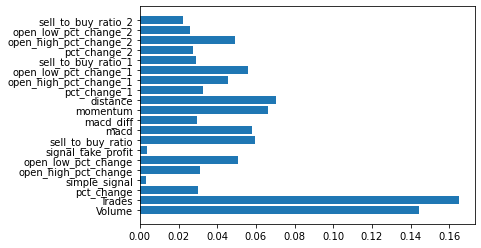

In [891]:
plt.barh(list(X), model_tp.feature_importances_)

In [892]:
# TODO:
# 1. Think on a model that would make for a good demo. There are several options:
#  a. Have labels that are related to some window in which the price changes significantly enough.
# We can reuse existing aggregations for such model.
#  b. Have a higher resolution of the aggregations (10k events instead of 1000 events for BTC). Can post-process existing data
# in fine resolution to arrive at new aggregations using a Python script.
#  c. Select a high-volume and high-volatility pair (e.g. ETHUSDT) that would yield signals more often.

In [893]:
# df.dropna(inplace=True)

In [894]:
# df.to_csv('ethbtc.csv', index=False)